In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
from datetime import datetime, timedelta
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
import re
import emoji
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
import gensim
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MaxAbsScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from spellchecker import SpellChecker
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import spacy
import swifter
from spacy.lang.en import English
from sklearn.base import BaseEstimator, TransformerMixin
from spacy.lang.en.stop_words import STOP_WORDS
import contractions
pd.set_option('display.max_colwidth', None)


In [2]:
df = pd.read_csv(r'C:\Users\Owner\Desktop\Mangimind Data Science Bootcamp\Machine Learning Project 3\tweet_data.csv\tweet_data.csv')

In [3]:
convert_dict = {'tweetID': str,
                'crDate': 'datetime64[ns]',
                'rtUsID': str,
                'usID': str }
df = df.astype(convert_dict)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785916 entries, 0 to 785915
Data columns (total 18 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   tweetID     785916 non-null  object        
 1   crDate      785916 non-null  datetime64[ns]
 2   edInput     785916 non-null  int64         
 3   editor      785916 non-null  int64         
 4   engages     785916 non-null  int64         
 5   isApproved  785916 non-null  bool          
 6   isEdNeed    785916 non-null  bool          
 7   isRT        785916 non-null  bool          
 8   likes       785916 non-null  int64         
 9   photoUrl    277896 non-null  object        
 10  retweets    785916 non-null  int64         
 11  rtUsID      785916 non-null  object        
 12  text        785916 non-null  object        
 13  topicName   785916 non-null  object        
 14  usFlwrs     785916 non-null  int64         
 15  usID        785916 non-null  object        
 16  us

In [5]:
#Let's have a look at the text 

list(df.iloc[11:19,12]),list(df.iloc[11:19,2])

(['Wall Street recovers slightly from earlier losses spurred by fears of U.S.-China tensions over trade, lower oil prices https://t.co/VPvaB9zruP https://t.co/0YOxbR7cAu',
  'New research suggests you should set harder goals\nhttps://t.co/GwI4wT7Uzr',
  'Judge orders U.S. State Department to disclose possible evidence whether Hillary Clinton used her private email to flout public information requests https://t.co/TTcrPnjQwD',
  '#RajasthanElection2018 LIVE: Voting begins, Satta market bets big on @INCIndia\n\nCatch #live updates here\n\n#RajasthanAssemblyelection2018 #RajasthanElections2018 #RajasthanElections\n\nhttps://t.co/mzTsOMm9an',
  "A room full of Alpine cheese is one of Bloomberg's photos of the week 🧀🧀🧀https://t.co/22LMFT1A6S https://t.co/D6PXWArXyb",
  '#TelanganaElection2018 LIVE: @narendramodi , @AmitShah urge people to vote in large numbers\n\nCatch all the #live updates here \n\n #TelanganaElections #TelanganaAssemblyElections2018 #TelanganaElections2018 #Telangana\n\nh

In [6]:
filtered_df = df[df['edInput'].isin([1,2])]
filtered_df['edInput'] = filtered_df['edInput'].replace(2,0)

C:\Users\Owner\AppData\Local\Temp\ipykernel_24020\584864609.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['edInput'] = filtered_df['edInput'].replace(2,0)


In [7]:
filtered_df

,tweetID,crDate,edInput,editor,engages,isApproved,isEdNeed,isRT,likes,photoUrl,retweets,rtUsID,text,topicName,usFlwrs,usID,usName,videoUrl
721,1070970722598707200,2018-12-07 09:18:12,1,5001,5137,True,True,False,4180,https://pbs.twimg.com/media/DtzaMK_W4AE6Vle.jpg,957,-1,Which one would you choose? 👀 https://t.co/U0s3alfBNp,Fashion,37293,1061553474918342656,Gentleman’s style,NaN
1374,1070981773616648193,2018-12-07 10:02:07,1,5003,52650,True,True,True,36349,NaN,16301,781427301472874497,How it’s made. 😊 https://t.co/3XjOw4gIkg,Interesting,34897,994950431234080768,Satisfying Slime,https://video.twimg.com/ext_tw_video/1070977723533836288/pu/vid/320x320/kT_NQKaQukLL0Lt0.mp4?tag=6
1867,916500037818916866,2017-10-07 03:06:51,0,5003,63872,False,True,True,39698,NaN,24174,821811651393495040,"Smile, because it confuses people. Smile, because it’s easier than explaining what is killing you inside. https://t.co/FGlnnRfP5w",Interesting,966840,482658470,Tips & Tricks Ideas ✌,NaN
2206,1071135340696625152,2018-12-07 20:12:20,1,5001,1714,True,True,False,1261,https://pbs.twimg.com/media/Dt1v6O9XgAIXOrR.jpg,453,-1,𝐶𝑙𝑎𝑢𝑑𝑒 𝑀𝑜𝑛𝑒𝑡 https://t.co/WdavWJcSyw,Art,33308,762649146,𝐴𝑟𝑡.,NaN
2263,1071141175606829056,2018-12-07 20:35:31,1,5001,62062,True,True,False,49073,NaN,12989,-1,Baby Alpacas are so under appreciated. https://t.co/SDXjKaVscv,Animal,1052924,2828212668,Nature is Amazing ☘️,https://video.twimg.com/ext_tw_video/1071141091351687169/pu/vid/320x320/yGOVTdWQoNNV2Lbe.mp4?tag=6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785850,1153952965650079744,2019-07-24 09:00:01,1,5005,20,True,True,True,10,https://pbs.twimg.com/media/D_h05AQXYAArdka.jpg,10,3197789991,Apply for a grant to implement plant conservation at your botanic garden today! https://t.co/gj2eDzIWeB https://t.co/z1iJjZPOFn,Flowers,5430,8224502,BGCI,NaN
785854,1154059414174703617,2019-07-24 16:03:00,0,5004,79,False,True,True,64,NaN,15,20562637,Are you team Shake Shack or team In-N-Out? https://t.co/3bDmzocr6P,Business,214552,4805771380,FOOD INSIDER,https://video.twimg.com/amplify_video/1037635783417585664/vid/720x720/k4TSpYTxCIGOIX-P.mp4?tag=8
785863,1154061474383441920,2019-07-24 16:11:11,1,5007,8,True,True,True,7,https://pbs.twimg.com/media/EAQMyyyXkAAQocF.jpg,1,529501969,How @OlafurEliasson's 'hedonistic' dad helped his art https://t.co/x9tFi65TjW @BBCHARDtalk @TheZeinabBadawi https://t.co/Ocuv6jrVbH,Art,57448,187869078,Phaidon,NaN
785871,1154130836217683968,2019-07-24 20:46:48,1,5007,15,True,True,True,9,NaN,6,314542577,I am delighted that @IfOnly and @Sothebys are offering a special auction lot to cook at my home with @CiaoSamin! Bidding ends Friday and proceeds support the @edibleschoolyrd! \n\nhttps://t.co/jmHg5unL2w,Art,102499,113509194,Alice Waters,NaN


In [8]:
# -1 unlabled data
# 1 confirmed by the editor that they are business calss
# 2 they confirmed they are misclassified. Editor does not agree
# 3 editor is confused
# 4 they are business but they were posted previously from another channel. If 4  it will noty be posted ot the user.
# eliminate three and four. Might want to included by relabling 4 as 1.
# stratification means your test splites has the same representation of all the classes. If your original has 30% of label 1 and 60 of label 2 your 

In [9]:
import matplotlib.pyplot as plt
from collections import Counter
def generate_word_frequency(df_column, top_n=20):
    words = " ".join(df_column).split()
    word_freq = Counter(words)
    
    # Top N most frequent words
    top_words = word_freq.most_common(top_n)
    words, frequencies = zip(*top_words)
    
    # Plot the word frequencies
    plt.figure(figsize=(10, 6))
    plt.bar(words, frequencies)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title('Word Frequencies')
    plt.xticks(rotation=90)
    plt.show()

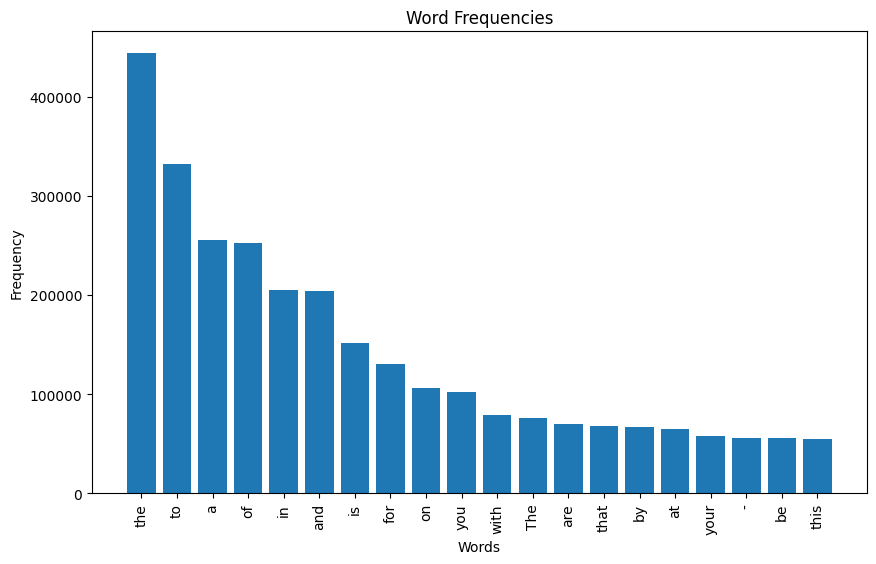

In [10]:
generate_word_frequency(df['text'], top_n=20)

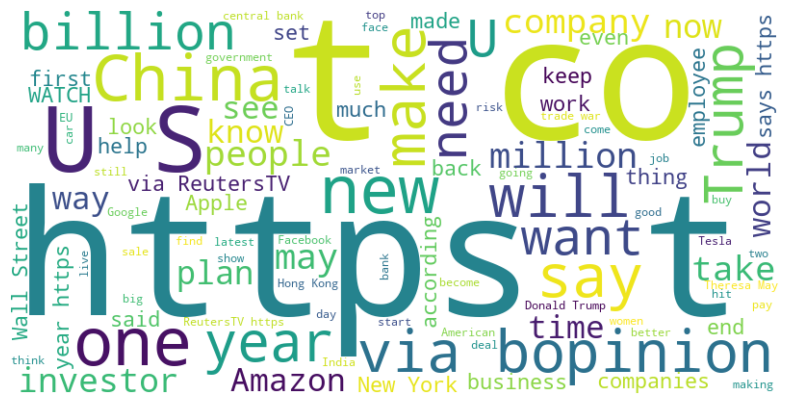

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
Biz_text = ' '.join(df[df['topicName'] == 'Business']['text'])
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(Biz_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

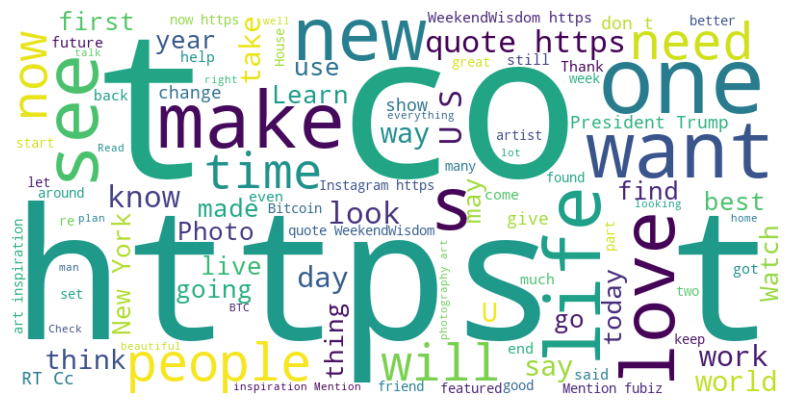

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
Non_Biz_text = ' '.join(df[df['topicName'] != 'Business']['text'])
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(Non_Biz_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [13]:
def clean_text(text):
    # Remove URLs and web links
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove special characters and punctuations
    text = re.sub(r'[^\w\s]', '', text)
    
    # Convert emojis to text representation
    text = emoji.demojize(text)
    
    # Remove the emoji delimiters (colons)
    text = re.sub(r':', '', text)
    
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [14]:
filtered_df['text'] = filtered_df['text'].swifter.apply(lambda x: clean_text(x))
filtered_df['text'] 

Pandas Apply:   0%|          | 0/322318 [00:00<?, ?it/s]

C:\Users\Owner\AppData\Local\Temp\ipykernel_24020\1191852929.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['text'] = filtered_df['text'].swifter.apply(lambda x: clean_text(x))


721                                                                                                                                                      Which one would you choose
1374                                                                                                                                                                   How its made
1867                                                                           Smile because it confuses people Smile because its easier than explaining what is killing you inside
2206                                                                                                                                                                   𝐶𝑙𝑎𝑢𝑑𝑒 𝑀𝑜𝑛𝑒𝑡
2263                                                                                                                                          Baby Alpacas are so under appreciated
                                                                                            ...     

In [15]:
def remove_unnecessary_characters(text):
    # Replace \n with space character
    cleaned_text = re.sub(r'\n+', ' ', text)
   
    # Remove special characters using regex
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Replace multiple spaces with a single space
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
    
    # Remove training and leading spaces
    cleaned_text = cleaned_text.strip()
    
    return cleaned_text

In [16]:
filtered_df['text'] = filtered_df['text'].swifter.apply(lambda x: remove_unnecessary_characters(x))
filtered_df['text']

Pandas Apply:   0%|          | 0/322318 [00:00<?, ?it/s]

C:\Users\Owner\AppData\Local\Temp\ipykernel_24020\1600408444.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['text'] = filtered_df['text'].swifter.apply(lambda x: remove_unnecessary_characters(x))


721                                                                                                                                                      Which one would you choose
1374                                                                                                                                                                   How its made
1867                                                                           Smile because it confuses people Smile because its easier than explaining what is killing you inside
2206                                                                                                                                                                               
2263                                                                                                                                          Baby Alpacas are so under appreciated
                                                                                            ...     

In [17]:
# Lowercase text
filtered_df['text'] = filtered_df['text'].str.lower()
# Expand contractions
filtered_df['text'] = filtered_df['text'].apply(contractions.fix)
# Print text
filtered_df['text']

C:\Users\Owner\AppData\Local\Temp\ipykernel_24020\1329557639.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['text'] = filtered_df['text'].str.lower()
C:\Users\Owner\AppData\Local\Temp\ipykernel_24020\1329557639.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['text'] = filtered_df['text'].apply(contractions.fix)


721                                                                                                                                                      which one would you choose
1374                                                                                                                                                                   how its made
1867                                                                           smile because it confuses people smile because its easier than explaining what is killing you inside
2206                                                                                                                                                                               
2263                                                                                                                                          baby alpacas are so under appreciated
                                                                                            ...     

In [21]:
import sala

In [28]:
sala['N10'].replace('None', 'vcv', inplace=True)


TypeError: 'module' object is not subscriptable

In [27]:
filtered_df['text'] = filtered_df['text'].str.lstrip()
filtered_df['text'] = filtered_df['text'].str.rstrip()
filtered_df['text'].head(2)

721     which one would you choose
1374                  how its made
Name: text, dtype: object

In [ ]:
def correct_spelling(text):
    if text is None:
        return text
    words = str(text).split()
    corrected_words = [spell.correction(word) for word in words if word is not None]
    corrected_words = [word for word in corrected_words if word is not None]
    corrected_text = ' '.join(corrected_words)
    return corrected_text

filtered_df['text'] = filtered_df['text'].swifter.apply(correct_spelling)

In [ ]:
#nlp = spacy.load('en_core_web_sm', disable=["parser", "ner"])
nlp = spacy.load('en_core_web_sm')

def lemmatize_text(text):
    doc = nlp(str(text))
    lemmatized_text = " ".join([token.lemma_ for token in doc])
    return lemmatized_text

filtered_df['lemmatized_text'] = filtered_df['text'].swifter.apply(lemmatize_text)

filtered_df['lemmatized_text'] = filtered_df['lemmatized_text'].swifter.apply(remove_stopwords)

filtered_df['lemmatized_text'] = filtered_df['lemmatized_text'].swifter.apply(lambda x: ' '.join(x))

filtered_df['lemmatized_text'].head(20)

In [ ]:
print(filtered_df['lemmatized_text'])

In [ ]:
filtered_df['text']

In [ ]:
#nlp = spacy.load('en_core_web_sm', disable=["parser", "ner"])
nlp = spacy.load('en_core_web_sm')
#doc = nlp(str(filtered_df['text']))

def lemmatize_text(text):
    # Process the text
    doc = nlp(str(text))
    
    lemmatized_text = " ".join([token.lemma_ for token in doc])
    return lemmatized_text

In [ ]:
# Lemmatize text
filtered_df['text'] = lemmatize_text(filtered_df['text'])
filtered_df['text'].head(20)

In [ ]:
# Replace empty strings with NaN and drop NaN rows
filtered_df['text'] = filtered_df['text'].replace('', np.nan)
filtered_df['text'] = filtered_df['text'].dropna()
filtered_df['text']

In [ ]:
# Tokenize the text and remove stop words
filtered_df['text'] = filtered_df['text'].apply(lambda x: ' '.join([token.text for token in nlp

In [ ]:
filtered_text.shape()

In [ ]:
nlp.max_length = 1_000_000

In [ ]:
# Remove configured stop words
filtered_df['text'] = filtered_df['text'].swifter.apply(lambda x: " ".join([token.text for token in nlp(x) if not token.is_stop]))

In [ ]:
filtered_df['text'] = filtered_df['text'].swifter.apply(lambda x: " ".join([token.text for token in nlp(x)]))

In [ ]:
filtered_df['text'] 

In [ ]:
X = filtered_df['text'].astype(str)1
y = filtered_df['edInput']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
